# Routing 

Everything concerning routing is better implemented in the PY file

In [74]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
from pyproj import CRS
import movingpandas as mpd
from datetime import datetime, timedelta

%matplotlib inline

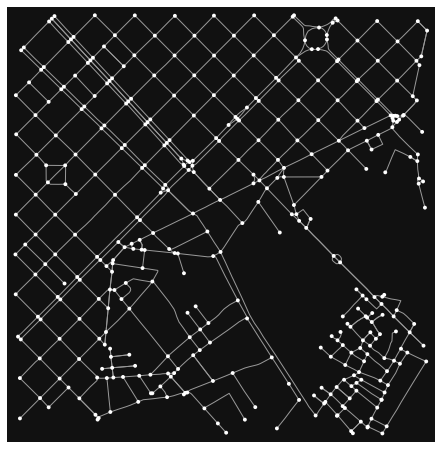

In [2]:
G_drive = ox.graph_from_address('Plaça Catalunya, Barcelona, Spain', dist = 1000, network_type = 'drive')
fig, ax = ox.plot_graph(G_drive)

In [91]:
G_drive.nodes[26057116]['x']

2.1701343

In [92]:
G_proj = ox.project_graph(G_drive)
G_proj.nodes[26057116]['x']

430615.2055030316

## Fast nearest node/ edge search

In [3]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(ox.project_graph(G_drive), nodes = True, edges = True )
gdf_nodes.head()

,y,x,osmid,lon,lat,highway,geometry
26057116,4.581913e+06,430615.205503,26057116,2.170134,41.385749,NaN,POINT (430615.206 4581912.558)
26057125,4.582096e+06,430485.753806,26057125,2.168565,41.387392,NaN,POINT (430485.754 4582096.186)
26057131,4.582250e+06,430803.670286,26057131,2.172350,41.388807,NaN,POINT (430803.670 4582250.293)
26057304,4.582006e+06,430294.831056,26057304,2.166292,41.386559,NaN,POINT (430294.831 4582005.567)
26057312,4.582341e+06,430471.786815,26057312,2.168370,41.389593,NaN,POINT (430471.787 4582340.683)


In [4]:
maxx = gdf_nodes['x'].max()
maxx

431609.20324725105

In [5]:
# Retrieve the node that is the most eastern one and get the Shapely Point geometry out of it
target = gdf_nodes.loc[gdf_nodes['x']==maxx, 'lon'].values[0]
print(target)

2.1819041


In [6]:
#convert the projected graph to edges goedataframe
gdf_edges = ox.graph_to_gdfs(ox.project_graph(G_zoom_drive), nodes = False )

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng

NameError: name 'G_zoom_drive' is not defined

In [7]:
# find the nearest node to some point
point = center_point
node = ox.get_nearest_node(ox.project_graph(G_zoom_drive), point)
node

NameError: name 'center_point' is not defined

In [186]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.get_nearest_nodes(ox.project_graph(G_zoom_drive), lngs, lats, method='kdtree')
nearest_nodes

array([216350784,  26057116,  26057304,  30254228,  26057131])

In [187]:
# find the nearest edge to some point
nearest_edge = ox.get_nearest_edge(ox.project_graph(G_zoom_drive), center_point)
print(nearest_edge)

(1362900007, 26057125, 0)


In [188]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.get_nearest_edges(ox.project_graph(G_zoom_drive), lngs, lats)
nearest_edges

array([[  26057116,  216350784,          0],
       [  26057116, 1126640615,          0],
       [  26057125,   26057304,          0],
       [  26057131,   30254228,          0],
       [  26057131, 5001160871,          0]])

## Basic routing by distance

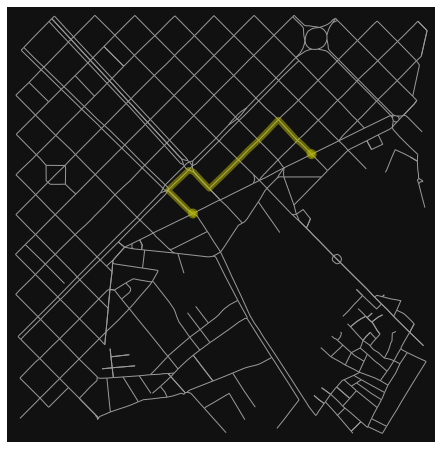

In [12]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_drive)[1]
dest = list(G_drive)[6]
#origin = (intersections[0].centroid.x,intersections[0].centroid.y)
#destination = (intersections[274].centroid.x,intersections[274].centroid.y)
#origin_node = ox.get_nearest_node(G_zoom_drive, origin)
#destination_node = ox.get_nearest_node(G_zoom_drive, destination)

route = ox.shortest_path(G_drive, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G_drive, route, route_color='y', route_linewidth=6, node_size=0)

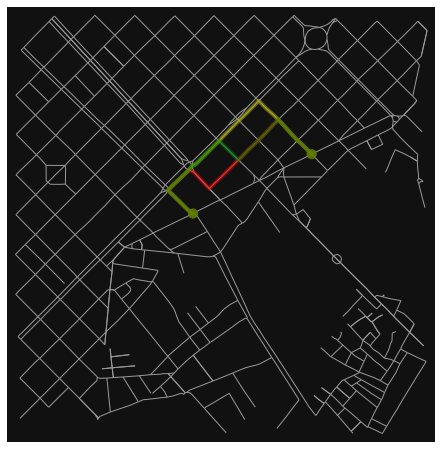

In [27]:
routes = ox.k_shortest_paths(G_drive, orig, dest, k=3, weight='length') # number of shortest paths
fig, ax = ox.plot_graph_routes(G_drive, list(routes), route_colors=['r','y','g'], route_linewidth=4, node_size=0, save = True, )

## Imputing travel speeds and times

In [14]:
# Since we dont have spped limits predetermined we use hwy_speed dict
hwy_speeds = {'residential': 35,
              'living_street': 20,
              'secondary': 50,
              'tertiary': 60}
G_drive = ox.add_edge_speeds(G_drive, hwy_speeds)

In [15]:
# calculate edge travel times
G_drive = ox.add_edge_travel_times(G_drive)

In [16]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G_drive, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",126.6,24.5,18.8
"['living_street', 'tertiary']",136.1,25.0,19.6
"['tertiary', 'secondary']",74.0,50.0,5.3
living_street,103.9,16.9,26.0
primary,86.1,50.0,6.2
primary_link,133.5,42.3,12.0
residential,91.2,30.5,11.2
secondary,96.5,49.5,7.0
secondary_link,40.8,47.5,3.1


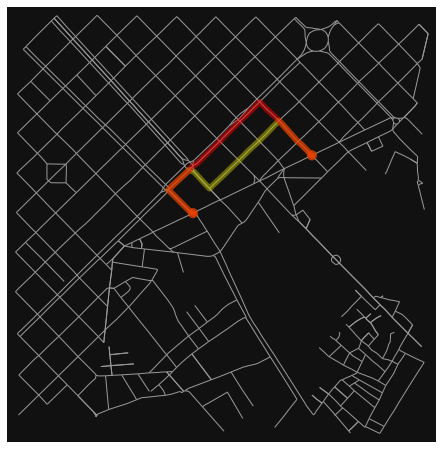

In [93]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G_drive)[1]
dest = list(G_drive)[6]
route1 = ox.shortest_path(G_proj, orig, dest, weight='length')
route2 = ox.shortest_path(G_proj, orig, dest, weight='travel_time')

# plot the routes
fig, ax = ox.plot_graph_routes(G_proj, routes=[route1, route2], route_colors=['y', 'r'],
                               route_linewidth=6, node_size=0)

Compare the two routes 

In [20]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_drive, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_drive, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_drive, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_drive, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 1126 meters and takes 122 seconds.
Route 2 is 1126 meters and takes 105 seconds.


### Get time for the route

In [ ]:
orig = list(G_drive)[1]
dest = list(G_drive)[6]

In [24]:
# OPTION 1: see the travel time for the whole route
nx.shortest_path_length(G_drive, orig, dest, weight='travel_time')

105.99999999999999

In [25]:
# OPTION 2: loop through the edges in your route
# and print the length and travel time of each edge
for u, v in zip(route2[:-1], route2[1:]):
    length = round(G_drive.edges[(u, v, 0)]['length'])
    travel_time = round(G_drive.edges[(u, v, 0)]['travel_time'])
    print(u, v, length, travel_time, sep='\t')

26057125	559765964	162	20
559765964	1375310919	137	10
1375310919	559032149	27	2
559032149	559787231	174	12
559787231	559787232	136	10
559787232	559787233	132	10
559787233	30242816	129	16
30242816	30242758	134	16
30242758	26057342	94	11


In [31]:
# OPTION 3: use get_route_edge_attributes
cols = ['osmid', 'length', 'travel_time']
attrs = ox.utils_graph.get_route_edge_attributes(G_drive, route)
print(pd.DataFrame(attrs)[cols])

                               osmid   length  travel_time
0               [8380873, 893745919]  162.478         19.5
1                          237522644  137.402          9.9
2                          126301386   26.272          1.9
3  [612296800, 549518619, 126301387]  108.220          7.8
4             [546148432, 526129884]  194.424         23.3
5                          579981378  133.692         16.0
6                          675305861  135.488         16.3
7                          675305862  133.816         16.1
8                          549538006   94.414         11.3


### Trajectory from route

In [78]:
df = pd.DataFrame()
nodes, lats, lngs, times = [], [], [], []
total_time = 0
first_node = True

for u, v in zip(route2[:-1], route2[1:]):
    length = round(G_drive.edges[(u, v, 0)]['length'])
    travel_time = round(G_drive.edges[(u, v, 0)]['travel_time'])
    #print(u, v, length, travel_time, sep='\t') 
    
    if first_node == True:
        nodes.append(u)
        lats.append(G_drive.nodes[u]['y'])
        lngs.append(G_drive.nodes[u]['x'])
        times.append(0)
        first_node = False
    
    nodes.append(v)
    lats.append(G_drive.nodes[v]['y'])
    lngs.append(G_drive.nodes[v]['x'])
    times.append(total_time + travel_time)
    total_time += travel_time
    

df['node'] = nodes
df['time'] = pd.to_timedelta(times, unit = 'S')
dfg = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lngs, lats))

dfg

,node,time,geometry
0,26057125,0 days 00:00:00,POINT (2.16857 41.38739)
1,559765964,0 days 00:00:20,POINT (2.16715 41.38839)
2,1375310919,0 days 00:00:30,POINT (2.16832 41.38925)
3,559032149,0 days 00:00:32,POINT (2.16853 41.38944)
4,559787231,0 days 00:00:44,POINT (2.17005 41.39050)
5,559787232,0 days 00:00:54,POINT (2.17119 41.39137)
6,559787233,0 days 00:01:04,POINT (2.17231 41.39221)
7,30242816,0 days 00:01:20,POINT (2.17343 41.39140)
8,30242758,0 days 00:01:36,POINT (2.17451 41.39052)
9,26057342,0 days 00:01:47,POINT (2.17533 41.38993)


In [80]:
gdf_trajectory = gpd.GeoDataFrame(dfg, crs=CRS(31256))
traj = mpd.Trajectory(gdf_trajectory, 0)
traj.df

,node,time,geometry
0,26057125,0 days 00:00:00,POINT (2.16857 41.38739)
1,559765964,0 days 00:00:20,POINT (2.16715 41.38839)
2,1375310919,0 days 00:00:30,POINT (2.16832 41.38925)
3,559032149,0 days 00:00:32,POINT (2.16853 41.38944)
4,559787231,0 days 00:00:44,POINT (2.17005 41.39050)
5,559787232,0 days 00:00:54,POINT (2.17119 41.39137)
6,559787233,0 days 00:01:04,POINT (2.17231 41.39221)
7,30242816,0 days 00:01:20,POINT (2.17343 41.39140)
8,30242758,0 days 00:01:36,POINT (2.17451 41.39052)
9,26057342,0 days 00:01:47,POINT (2.17533 41.38993)


In [75]:
timedate = datetime(year=2021, month=10, day=10, hour= 11, minute=0, second=0)

In [81]:
traj.df.loc[:,'time'] = traj.df.loc[:,'time'] + timedate
traj.df.set_index('time', inplace=True)

In [82]:
traj.df

,node,geometry
time,,
2021-10-10 11:00:00,26057125,POINT (2.16857 41.38739)
2021-10-10 11:00:20,559765964,POINT (2.16715 41.38839)
2021-10-10 11:00:30,1375310919,POINT (2.16832 41.38925)
2021-10-10 11:00:32,559032149,POINT (2.16853 41.38944)
2021-10-10 11:00:44,559787231,POINT (2.17005 41.39050)
2021-10-10 11:00:54,559787232,POINT (2.17119 41.39137)
2021-10-10 11:01:04,559787233,POINT (2.17231 41.39221)
2021-10-10 11:01:20,30242816,POINT (2.17343 41.39140)
2021-10-10 11:01:36,30242758,POINT (2.17451 41.39052)


In [85]:
print(traj.get_position_at(datetime(year=2021, month=10, day=10, hour= 11, minute=0, second=25)))

POINT (2.16773225 41.3888211)


### Route from coordinates 

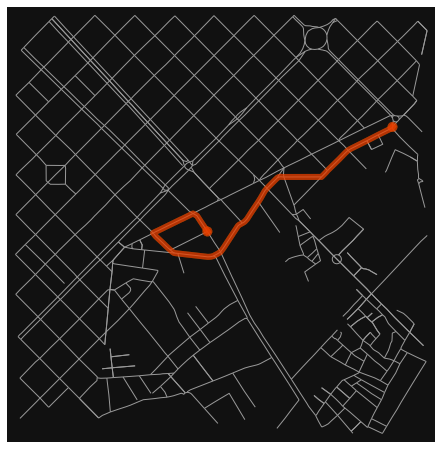

In [214]:
origin = (41.387026, 2.170115)
destination = (41.391055, 2.180111)
origin_node = ox.get_nearest_node(G_zoom_drive, origin)
destination_node = ox.get_nearest_node(G_zoom_drive, destination)
route1 = ox.shortest_path(G_zoom_drive, origin_node, destination_node, weight='length')
route2 = ox.shortest_path(G_zoom_drive, origin_node, destination_node, weight='travel_time')
# plot the routes
fig, ax = ox.plot_graph_routes(G_zoom_drive, routes=[route1, route2], route_colors=['y', 'r'],
                               route_linewidth=6, node_size=0)